In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# hyperparams
input_channels = 1
hidden_channels = 64 * 2
n_epochs = 15
batch_size = int(128 / 2)

device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.',
                               train=True,
                               download=True,
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

dataset_test = datasets.MNIST('.',
                              train=False,
                              download=True,
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

In [13]:
def train_model(train_dataloader, model):
  train_loss = 0

  model.train()
    
  for i, batch in enumerate(train_dataloader):
    inputs, labels = batch
    optim.zero_grad()

    predict = model(inputs.to(device))
    loss = loss_func(inputs.to(device), predict)

    loss.backward()
    optim.step()

    train_loss += loss.item()

  return train_loss

In [14]:
def validate_model(test_dataloader, model):
  test_loss = 0

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        inputs, labels = batch
        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)

        test_loss += loss.item()

  return test_loss

In [15]:
def compute_accuracy(model, dataloader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['data'], batch['target']
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

**Задание1 - обучить AE собственной архитектуры**

In [16]:
class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1,
                           padding=2)
    
    self.do1 = nn.Dropout(0.2)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1,
                           padding=1)
    
    self.do2 = nn.Dropout(0.2)
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7 = 49
    
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,
                           padding=1)
    self.activ = nn.ReLU()
    self.softmax = nn.Sigmoid()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))

    return self.conv3(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1,
                           padding=1)
    self.do1 = nn.Dropout(0.2)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1,
                           padding=1)    
    self.do2 = nn.Dropout(0.2)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1,
                           padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))

    return self.conv3(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [17]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE


Epoch [1/15], Train Loss: 0.1128, Val Loss: 0.1161


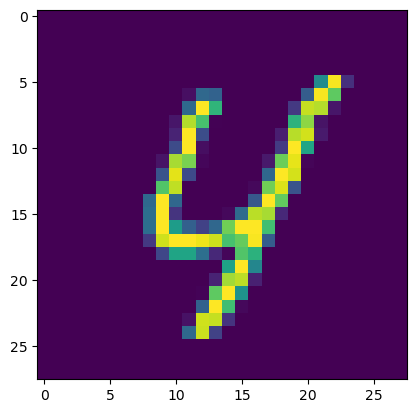

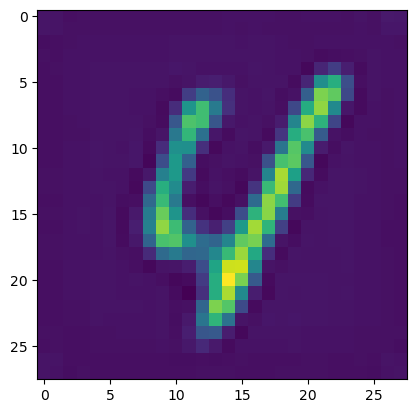

Epoch [2/15], Train Loss: 0.1040, Val Loss: 0.1125


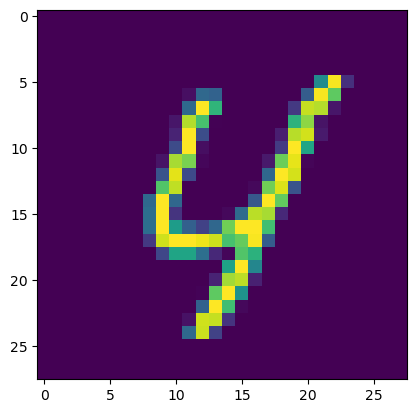

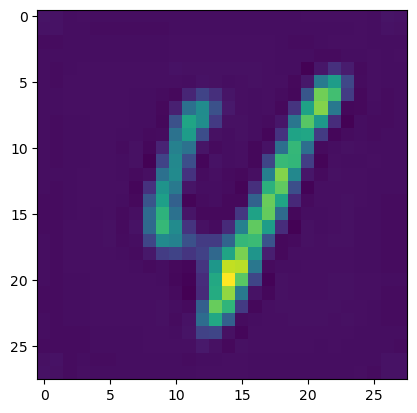

Epoch [3/15], Train Loss: 0.0984, Val Loss: 0.1093


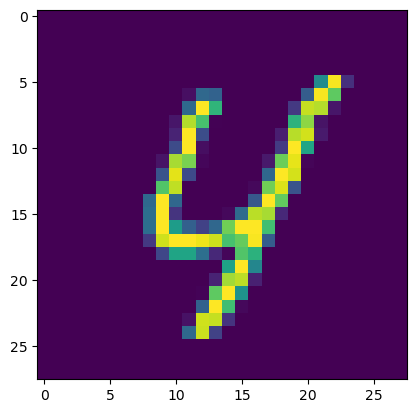

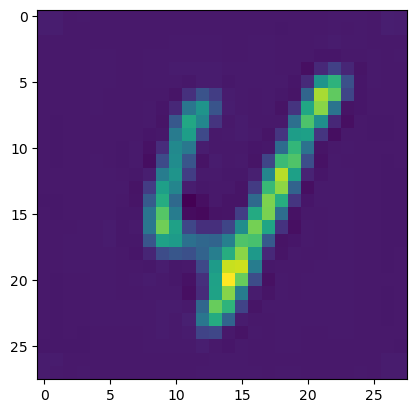

Epoch [4/15], Train Loss: 0.0934, Val Loss: 0.1003


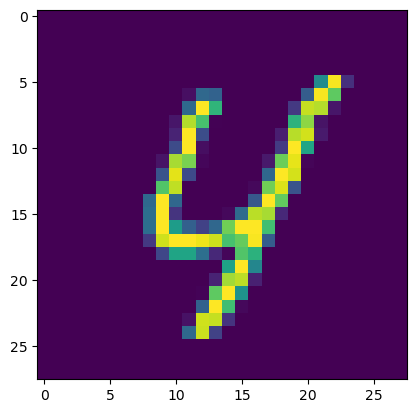

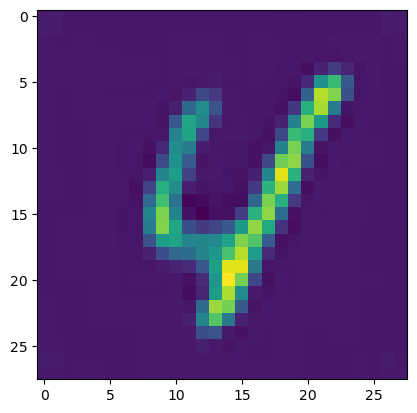

Epoch [5/15], Train Loss: 0.0892, Val Loss: 0.0987


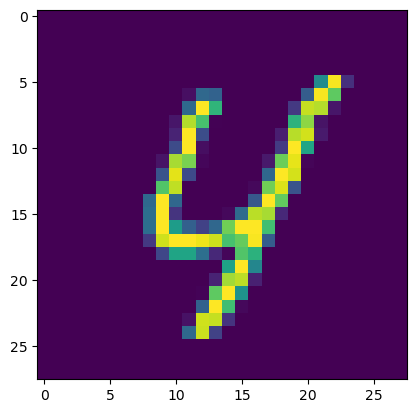

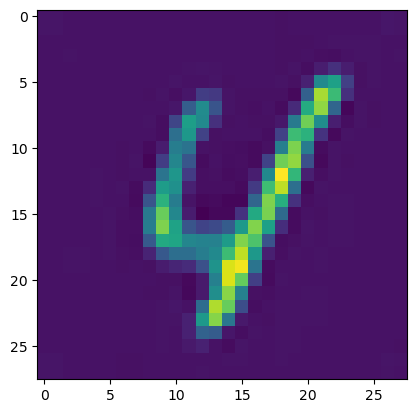

Epoch [6/15], Train Loss: 0.0857, Val Loss: 0.0973


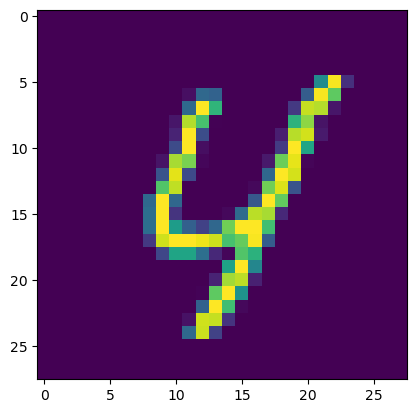

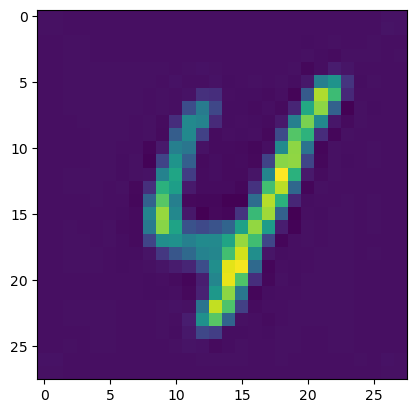

Epoch [7/15], Train Loss: 0.0827, Val Loss: 0.1012


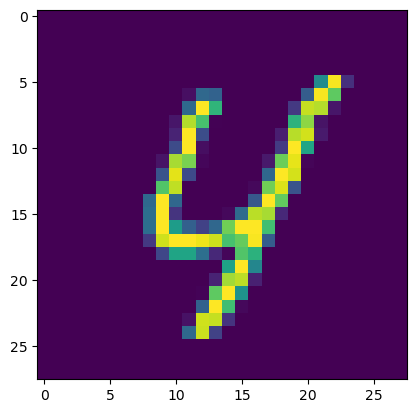

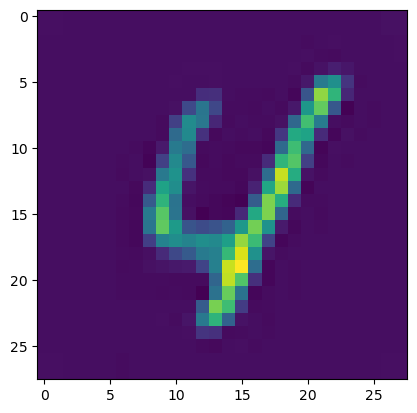

Epoch [8/15], Train Loss: 0.0806, Val Loss: 0.1032


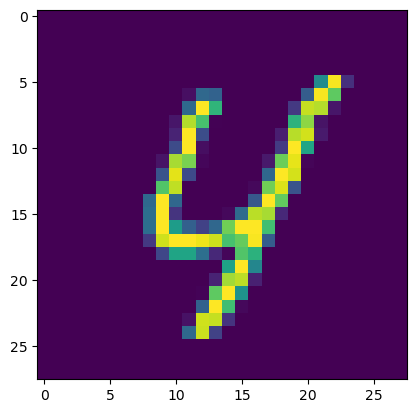

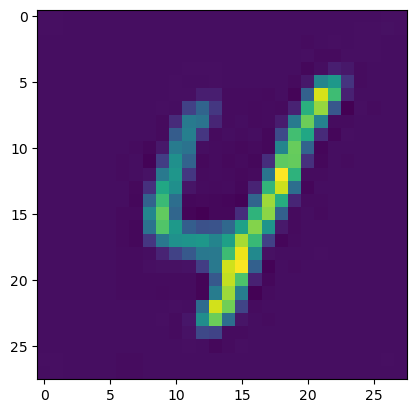

Epoch [9/15], Train Loss: 0.0786, Val Loss: 0.0983


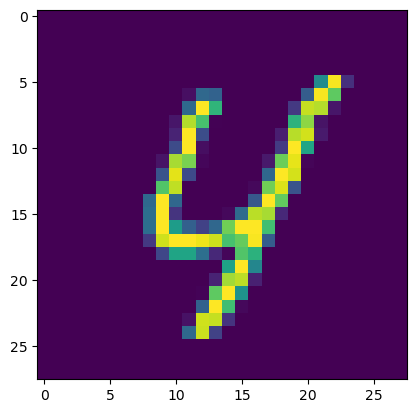

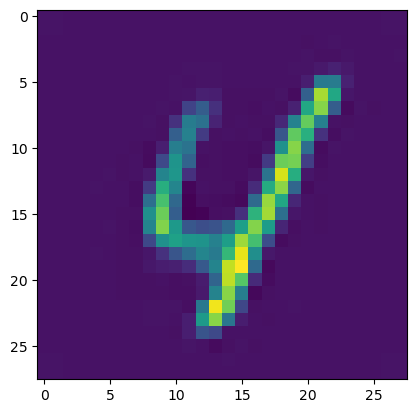

Epoch [10/15], Train Loss: 0.0768, Val Loss: 0.1110


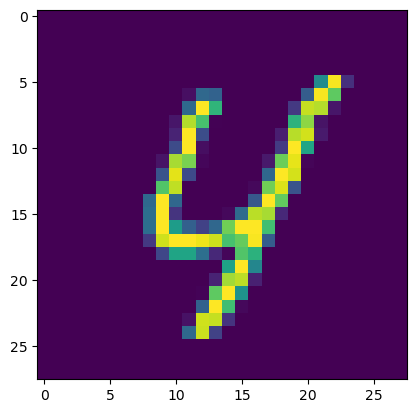

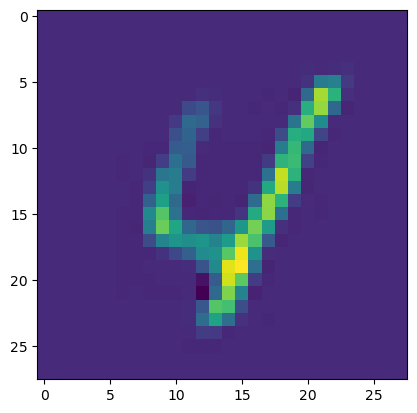

Epoch [11/15], Train Loss: 0.0749, Val Loss: 0.1012


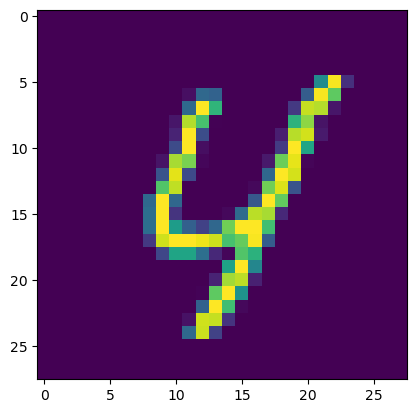

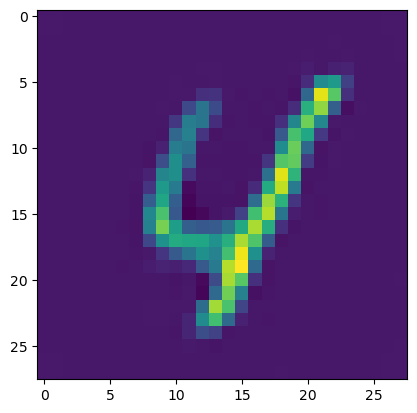

Epoch [12/15], Train Loss: 0.0735, Val Loss: 0.0969


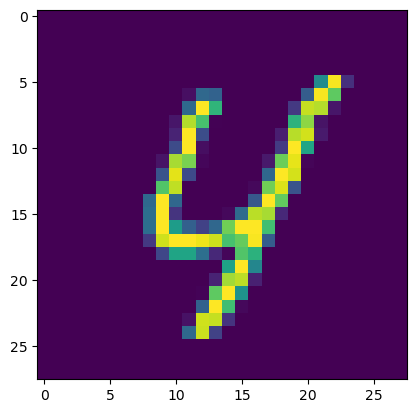

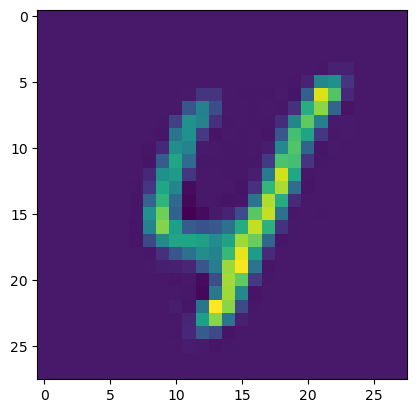

Epoch [13/15], Train Loss: 0.0716, Val Loss: 0.0988


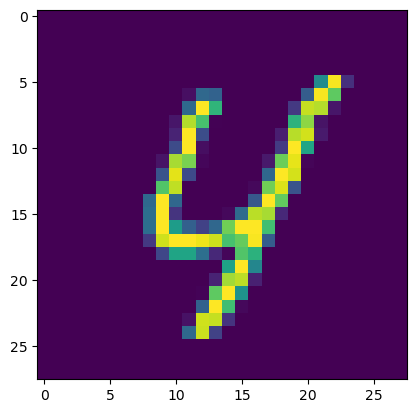

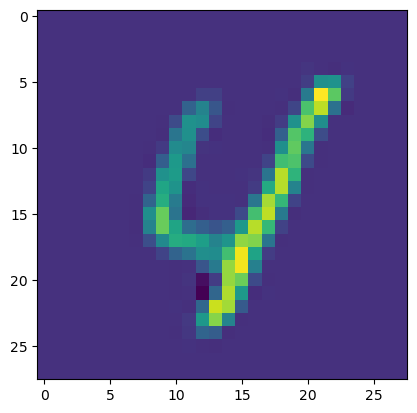

Epoch [14/15], Train Loss: 0.0699, Val Loss: 0.0976


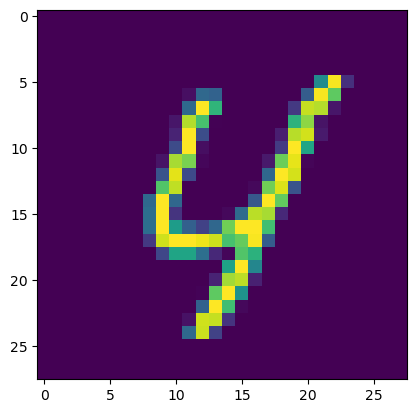

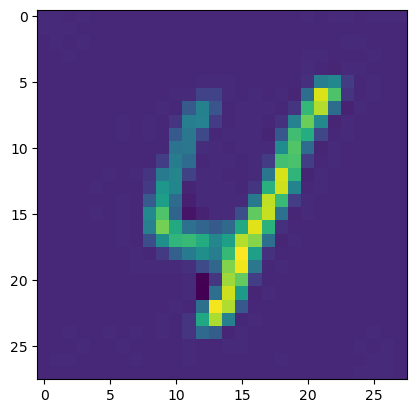

Epoch [15/15], Train Loss: 0.0692, Val Loss: 0.0956


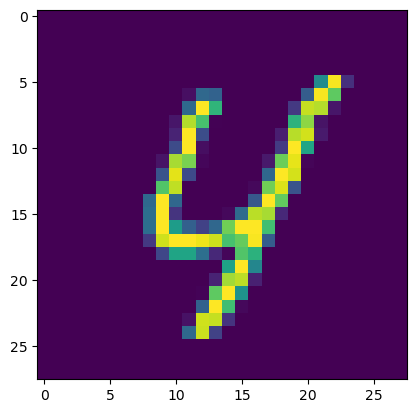

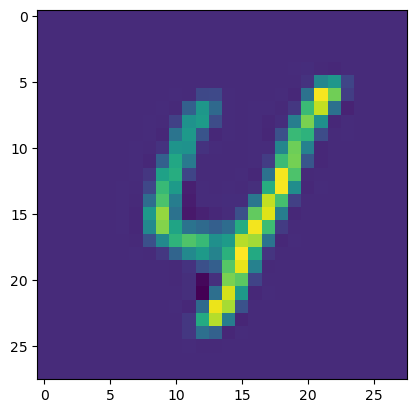

In [19]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    
#     for i, batch in enumerate(trainloader):
#         inputs, labels = batch
#         optim.zero_grad()

#         predict = model(inputs.to(device))
#         loss = loss_func(inputs.to(device), predict)
#         loss.backward()
#         optim.step()
        
    train_loss += train_model(trainloader, model)
    test_loss += validate_model(testloader, model)

    train_losses.append(train_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))
       
    print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')
    
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

In [14]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1,
                           padding=2) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1,
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,
                           padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1,
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1,
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1,
                           padding=2) # 28x28
    self.activ = nn.ReLU()
    self.emb = nn.Embedding(10, 49)

  def forward(self, x, digit):
    x = x + self.emb(digit)
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.conv3(x)


    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.8383513689041138
epoch: 0, step: 200, loss: 0.1878378987312317
epoch: 0, step: 400, loss: 0.16887059807777405


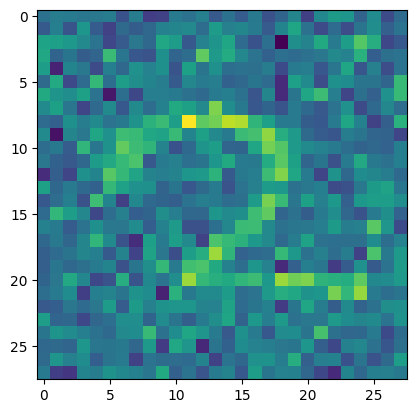

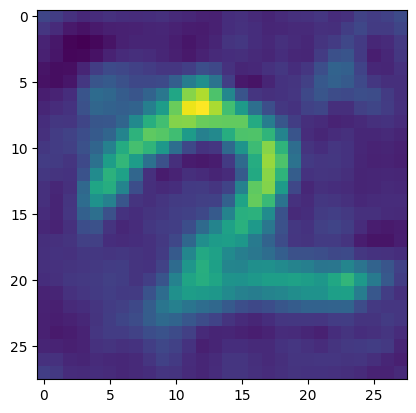

epoch: 1, step: 0, loss: 0.17034371197223663
epoch: 1, step: 200, loss: 0.16096147894859314
epoch: 1, step: 400, loss: 0.15827637910842896


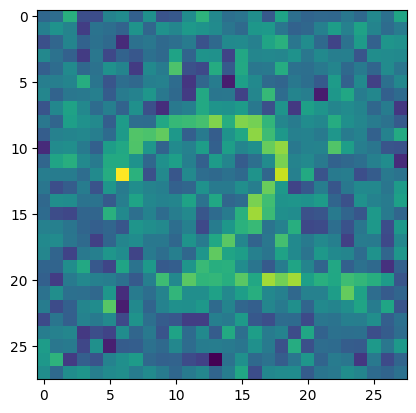

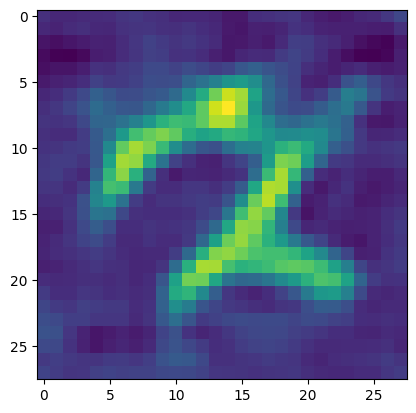

epoch: 2, step: 0, loss: 0.1665542721748352
epoch: 2, step: 200, loss: 0.15940222144126892
epoch: 2, step: 400, loss: 0.15016405284404755


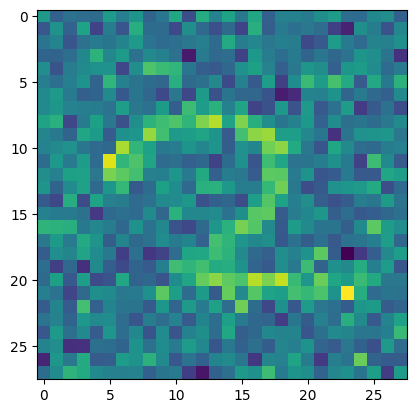

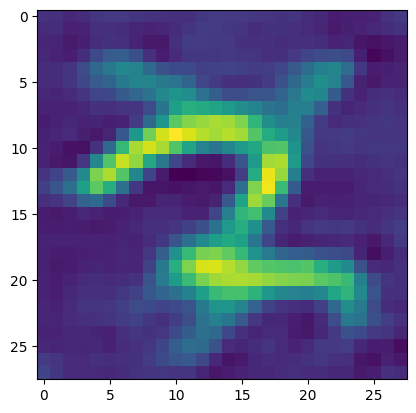

In [33]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.1 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[77][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

In [28]:
item = dataset_test[77][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)
print(mu, sigma)

tensor([[[[ 0.0347,  0.3260,  0.7558,  1.0465,  0.9260,  0.5405,  0.2073],
          [ 0.0456,  1.0430, -0.3644, -0.8915, -0.4841,  0.7678,  0.4195],
          [ 0.8878, -1.2440, -0.9440,  0.4091, -1.4376, -0.6285,  0.6725],
          [ 0.5219, -0.3094,  0.8215,  0.8847, -1.0970,  0.7409,  0.7287],
          [ 0.3471,  0.9439,  0.2923, -1.6693,  0.1087, -0.0564, -0.7836],
          [ 0.0784,  0.7767, -0.4627,  0.0563, -0.6475, -0.7907, -0.4213],
          [-0.0032,  0.4221,  0.7993,  0.7498,  1.0761,  0.9449,  0.4169]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>) tensor([[[[0.9557, 0.7809, 0.7159, 0.6071, 0.6287, 0.7349, 0.7885],
          [0.9362, 0.5031, 0.2935, 0.3144, 0.3272, 0.4156, 0.7260],
          [0.6856, 0.3357, 0.2401, 0.2675, 0.2895, 0.3538, 0.6848],
          [0.7281, 0.3929, 0.5157, 0.3240, 0.3035, 0.4335, 0.6440],
          [0.7878, 0.6373, 0.3569, 0.3294, 0.2959, 0.2882, 0.3883],
          [0.8865, 0.6054, 0.3416, 0.3143, 0.3564, 0.2974, 0.4358],
        

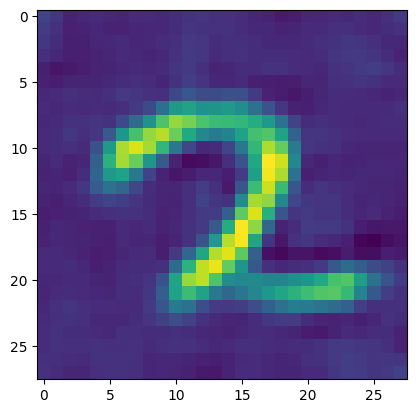

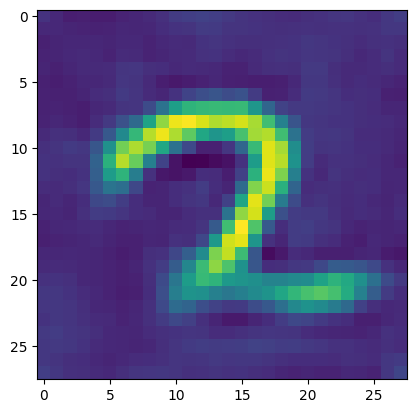

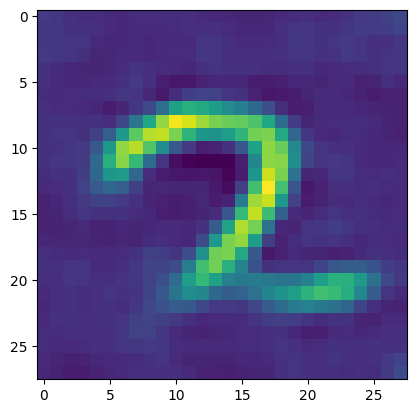

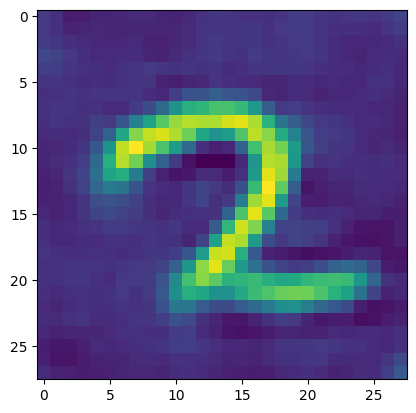

In [32]:

for _ in range(4):
    hid = torch.normal(mu.cpu(), sigma.cpu()*0.1).to(device)

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()